# Area and Population the Federative units of Brazil

## Introduction

This project is proposed to do an analysis of how the population is spread all around the federative units of Brazil.

We use dataset from different sources, one from [mapaslivres](https://github.com/mapaslivres) and another coming out of web scraping of [wikipedia](https://pt.wikipedia.org/wiki/Lista_de_munic%C3%ADpios_brasileiros_por_%C3%A1rea_decrescente). The first dataset provides infomation about city code, federative unit code, name, longitude, latitude, population et cetera. The second gives city, federative unit names and area.

## Data Preparation and Cleaning

We will prepare the environment, load, scrape and assess dataset. Subsequently, we also clean and process the data for analysis.

In [1]:
# Some important modules to scrape a website
from bs4 import BeautifulSoup
import requests
import sys

# Modules to create a dataframe, to plot and mathematical functions

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 
%matplotlib inline 

In [2]:
# Load data into pandas DadaFrame 
cities_df1 = pd.read_csv("data/municipios.csv")
cities_df1.head()

,municipio,uf,uf_code,name,mesoregion,microregion,rgint,rgi,osm_relation_id,wikidata_id,is_capital,wikipedia_pt,lon,lat,no_accents,slug_name,alternative_names,pop_21
0,1100015,11,RO,Alta Floresta d'Oeste,1102,11006,1102,110005,325842,Q1761456,NaN,Alta Floresta d'Oeste,-61.999824,-11.935540,Alta Floresta d'Oeste,alta-floresta-doeste,NaN,22516
1,1100023,11,RO,Ariquemes,1102,11003,1101,110002,325888,Q1646975,NaN,Ariquemes,-63.033269,-9.908463,Ariquemes,ariquemes,NaN,111148
2,1100031,11,RO,Cabixi,1102,11008,1102,110006,325882,Q940433,NaN,Cabixi,-60.544314,-13.499763,Cabixi,cabixi,NaN,5067
3,1100049,11,RO,Cacoal,1102,11006,1102,110005,325872,Q1761637,NaN,Cacoal,-61.442944,-11.433865,Cacoal,cacoal,NaN,86416
4,1100056,11,RO,Cerejeiras,1102,11008,1102,110006,325883,Q1803210,NaN,Cerejeiras,-60.818426,-13.195033,Cerejeiras,cerejeiras,NaN,16088


In [3]:
# Dimensionality of the cities_df1
cities_df1.shape

(5570, 18)

In [4]:
# Information about cities1 dataframe including the index dtype and columns, non-null values and memory usage.
cities_df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5570 entries, 0 to 5569
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   municipio          5570 non-null   int64  
 1   uf                 5570 non-null   int64  
 2   uf_code            5570 non-null   object 
 3   name               5570 non-null   object 
 4   mesoregion         5570 non-null   int64  
 5   microregion        5570 non-null   int64  
 6   rgint              5570 non-null   int64  
 7   rgi                5570 non-null   int64  
 8   osm_relation_id    5570 non-null   int64  
 9   wikidata_id        5570 non-null   object 
 10  is_capital         27 non-null     object 
 11  wikipedia_pt       5570 non-null   object 
 12  lon                5570 non-null   float64
 13  lat                5570 non-null   float64
 14  no_accents         5570 non-null   object 
 15  slug_name          5570 non-null   object 
 16  alternative_names  1 non

In [5]:
# Check null values
cities_df1.isnull().sum()

municipio               0
uf                      0
uf_code                 0
name                    0
mesoregion              0
microregion             0
rgint                   0
rgi                     0
osm_relation_id         0
wikidata_id             0
is_capital           5543
wikipedia_pt            0
lon                     0
lat                     0
no_accents              0
slug_name               0
alternative_names    5569
pop_21                  0
dtype: int64

In [6]:
# Modifying the names and drop some columns
cities_df1.drop(['uf', 'mesoregion', 'microregion', 'rgint', 'rgi', 'osm_relation_id', 'wikipedia_pt', 
                 'is_capital', 'wikidata_id', 'no_accents', 'slug_name', 'alternative_names'], axis=1, inplace=True)

cities_df1.rename({'municipio': 'city_code', 'uf_code': 'fu_acr', 'name': 'city_name', 'pop_21': 'pop'}, axis=1, inplace=True)

cities_df1

,city_code,fu_acr,city_name,lon,lat,pop
0,1100015,RO,Alta Floresta d'Oeste,-61.999824,-11.935540,22516
1,1100023,RO,Ariquemes,-63.033269,-9.908463,111148
2,1100031,RO,Cabixi,-60.544314,-13.499763,5067
3,1100049,RO,Cacoal,-61.442944,-11.433865,86416
4,1100056,RO,Cerejeiras,-60.818426,-13.195033,16088
...,...,...,...,...,...,...
5565,5222005,GO,Vianópolis,-48.513471,-16.742081,14088
5566,5222054,GO,Vicentinópolis,-49.807239,-17.732662,9002
5567,5222203,GO,Vila Boa,-47.057361,-15.034889,6451
5568,5222302,GO,Vila Propício,-48.882422,-15.454635,5941


## Web Scraping

In [7]:
# HTTP headers let the client and the server pass additional information with an HTTP request or response.
headers = {'User-Agent': "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:108.0) Gecko/20100101 Firefox/108.0"}

# Perform a GET type request and check if the response had a status code 200
url = "https://pt.wikipedia.org/wiki/Lista_de_munic%C3%ADpios_brasileiros_por_%C3%A1rea_decrescente"

page = requests.get(url, headers=headers)

if page.status_code != 200:
    sys.exit('Non 200 status code received')

In [8]:
# Parse the html into the 'page' variable and store it in Beautiful Soup format
soup = BeautifulSoup(page.content, "html.parser")

# Table with all information
table = soup.find_all('table')[0]
rows = table.find_all('tr')
row_list = list()

for tr in rows:
    td = tr.find_all('td')
    row = [i.text for i in td]
    row_list.append(row)

In [9]:
# Insert data obtained by scraping into pandas dataframe
cities_df2 = pd.DataFrame(row_list,columns=['col1','city_name','city_code', 'fu_name', 'area'])
cities_df2.head()

,col1,city_name,city_code,fu_name,area
0,None,None,None,None,None
1,1,Altamira,1500602,Pará,"159 533,328\n"
2,2,Barcelos,1300409,Amazonas,"122 461,086\n"
3,3,São Gabriel da Cachoeira,1303809,Amazonas,"109 181,245\n"
4,4,Oriximiná,1505304,Pará,"107 613,838\n"


In [10]:
cities_df2.isnull().sum()

col1         1
city_name    1
city_code    1
fu_name      1
area         1
dtype: int64

In [11]:
cities_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5571 entries, 0 to 5570
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   col1       5570 non-null   object
 1   city_name  5570 non-null   object
 2   city_code  5570 non-null   object
 3   fu_name    5570 non-null   object
 4   area       5570 non-null   object
dtypes: object(5)
memory usage: 217.7+ KB


In [12]:
# Drop first row and column
cities_df2.drop(index=0, inplace=True)
cities_df2.drop('col1', axis=1, inplace=True)
cities_df2.drop('city_name', axis=1, inplace=True)

# Replace \n or \r or \t 
cities_df2 = cities_df2.replace(r'\r+|\n+|\t+','', regex=True)

# Replace whitespace in column 'area' and ',' to '.'
cities_df2['area'] = cities_df2['area'].str.replace(u"\xa0","")
cities_df2['area'] = cities_df2['area'].str.replace(",",".")

# Reset index
cities_df2.reset_index(drop=True, inplace=True)

# Modifying the type column
cities_df2['area'] = cities_df2['area'].astype(float)
cities_df2['city_code'] = cities_df2['city_code'].astype(int)

In [13]:
# Check null values
cities_df2.isnull().sum()

city_code    0
fu_name      0
area         0
dtype: int64

In [14]:
# Merge the dataframes to obtain a unified table with all information
new_df = pd.merge(cities_df1, cities_df2, how = 'inner', on=['city_code'])
new_df.head()

,city_code,fu_acr,city_name,lon,lat,pop,fu_name,area
0,1100015,RO,Alta Floresta d'Oeste,-61.999824,-11.935540,22516,Rondônia,7067.025
1,1100023,RO,Ariquemes,-63.033269,-9.908463,111148,Rondônia,4426.571
2,1100031,RO,Cabixi,-60.544314,-13.499763,5067,Rondônia,1314.352
3,1100049,RO,Cacoal,-61.442944,-11.433865,86416,Rondônia,3792.892
4,1100056,RO,Cerejeiras,-60.818426,-13.195033,16088,Rondônia,2783.300


In [15]:
new_df.shape

(5570, 8)

In [16]:
new_df.isnull().sum()

city_code    0
fu_acr       0
city_name    0
lon          0
lat          0
pop          0
fu_name      0
area         0
dtype: int64

In [17]:
# Let is confirm that the dataset does not contain any country with negative population and area
(new_df.iloc[:, 5::2].values < 0).any()

False

## Exploratory Analysis and Visualization

Before we go into asking questions from the dataset, it would be useful for us to understand what and how data is stored in the dataset. Along with this we might also encounter some bias in the dataset.

### Most densely populated countries in the Brazil

We can compute the population density from the population and area columns and see Brazil's most densely populated federative units.

In [18]:
# Compute the population density
new_df['pop_density'] = round(new_df['pop']/new_df['area'], 3)
new_df.sort_values('pop_density', ascending=False).head(5)

,city_code,fu_acr,city_name,lon,lat,pop,fu_name,area,pop_density
3855,3552809,SP,Taboão da Serra,-46.785780,-23.623328,297528,São Paulo,20.388,14593.290
3419,3513801,SP,Diadema,-46.623381,-23.689295,429550,São Paulo,30.732,13977.288
3249,3305109,RJ,São João de Meriti,-43.371885,-22.802331,473385,Rio de Janeiro,35.216,13442.327
3388,3510609,SP,Carapicuíba,-46.841445,-23.535249,405375,São Paulo,34.546,11734.354
3654,3534401,SP,Osasco,-46.788810,-23.533612,701428,São Paulo,64.954,10798.842


Four of the five most densely populated cities are in the state of São Paulo.

### Largest Population

Since this analysis is to understand Brazilian population let us first get a bar graph containing the most populous.

In [19]:
highest_population = new_df.sort_values('pop', ascending=False).head(10)
highest_population

,city_code,fu_acr,city_name,lon,lat,pop,fu_name,area,pop_density
3829,3550308,SP,São Paulo,-46.570383,-23.567387,12396372,São Paulo,1521.110,8149.557
3242,3304557,RJ,Rio de Janeiro,-43.227875,-22.876652,6775561,Rio de Janeiro,1200.329,5644.753
5569,5300108,DF,Brasília,-47.887905,-15.794087,3094325,Distrito Federal,5760.783,537.136
2162,2927408,BA,Salvador,-38.488061,-13.014772,2900319,Bahia,693.453,4182.431
949,2304400,CE,Fortaleza,-38.589928,-3.723805,2703391,Ceará,312.353,8654.922
2309,3106200,MG,Belo Horizonte,-43.926453,-19.937524,2530701,Minas Gerais,331.354,7637.454
111,1302603,AM,Manaus,-60.023335,-3.134691,2255903,Amazonas,11401.092,197.867
4005,4106902,PR,Curitiba,-49.271848,-25.432956,1963726,Paraná,434.892,4515.434
1596,2611606,PE,Recife,-34.888942,-8.062762,1661017,Pernambuco,218.843,7589.994
5417,5208707,GO,Goiânia,-49.255814,-16.673310,1555626,Goiás,728.841,2134.383


The ten most populous cities in brazil are the capitals of their federative units.

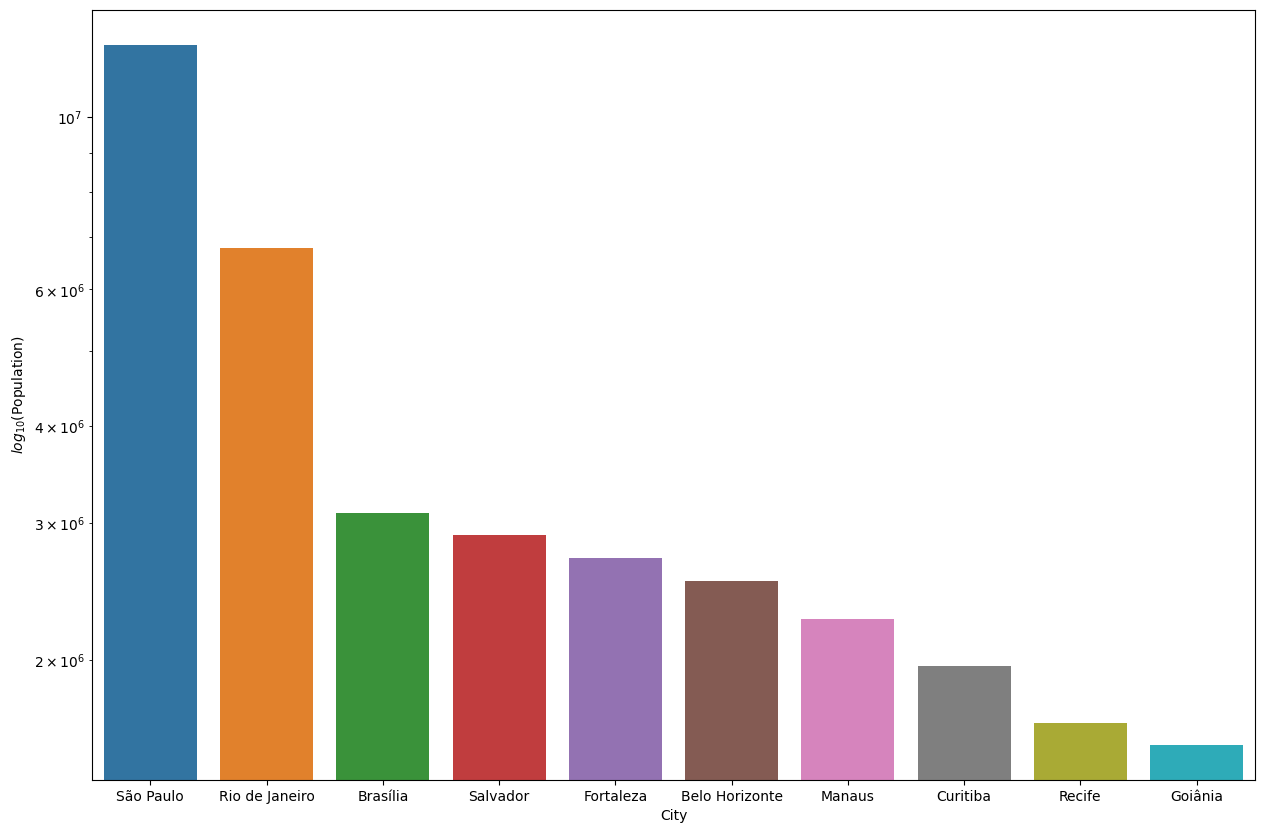

In [20]:
# To visualize the above data, let us use barplot from the seaborn library.
plt.figure(figsize=(15,10))
ax = sns.barplot(x = 'city_name', y = 'pop', data = highest_population)
ax.set_yscale('log')
plt.xlabel('City')
plt.ylabel('$log_{10}$(Population)')
plt.show()

### Plotting Population against Area

Since different Brazil federative units have different population, it is a good idea to make a scatter plot that helps us relate a population with its area.

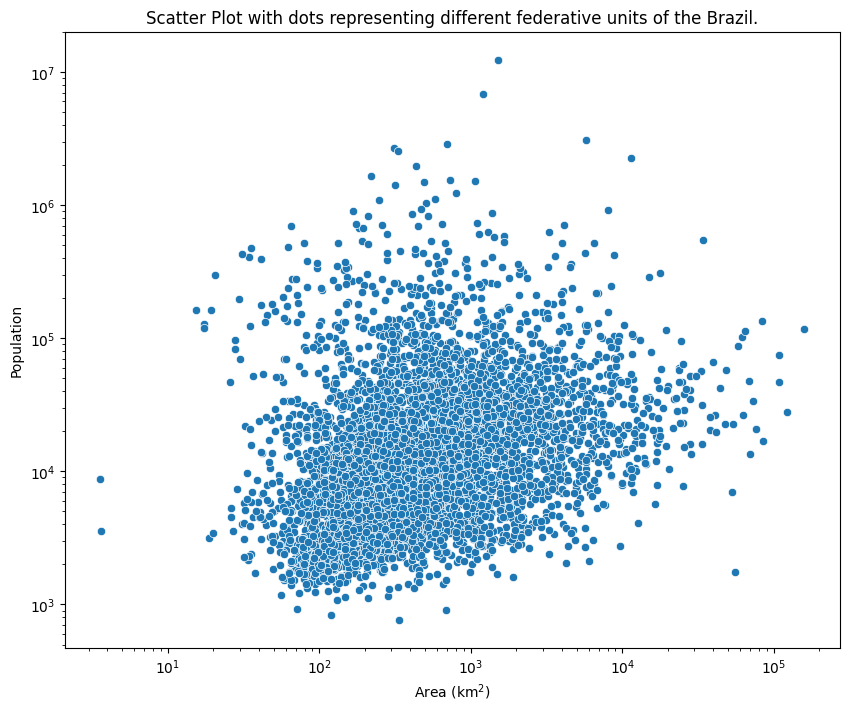

In [21]:
plt.figure(figsize=(10,8))
plt.title("Scatter Plot with dots representing different federative units of the Brazil.")

ax = sns.scatterplot(x=new_df['area'], y=new_df['pop'], data=new_df)
plt.xlabel('Area (km$^2$)')
plt.ylabel('Population')
ax.set_yscale('log')
ax.set_xscale('log')
plt.show()

### What percentage do federative units occupy in Brazil? And the population?

In [22]:
# Area and population of Brazil
area_Brazil = new_df['area'].sum()
population_Brazil = new_df['pop'].sum()

# Grouped by federative units 
group = new_df.groupby('fu_name')[['pop', 'area']].sum()
area_unit  = group['area']
population_states = group['pop']

# area_relative
area_relative = (group.area/area_Brazil )*100
population_relative = (group['pop']/population_Brazil)*100

conc = pd.concat([area_relative, population_relative], axis=1, keys=['Area Relative', 'Population Relative'])

conc.sort_values(by='Area Relative', ascending=False).head(5)

,Area Relative,Population Relative
fu_name,,
Amazonas,18.349139,2.001707
Pará,14.662087,4.114580
Mato Grosso,10.629433,1.672264
Minas Gerais,6.902501,10.037577
Bahia,6.646409,7.024869


The Federative Unit of Amazonas represents approximately 18% and 2% territory and population, respectively.

In [23]:
conc.sort_values(by='Population Relative', ascending=True).head(5)

,Area Relative,Population Relative
fu_name,,
Roraima,2.631971,0.305982
Amapá,1.676674,0.411411
Acre,1.931500,0.425129
Tocantins,3.265380,0.753507
Rondônia,2.798151,0.850974


Roraima has 2.60% of area and 0.30% of population.

### Rio Grande do Norte and your cities

In [24]:
# group by Rio Grande do Norte
df_RN = new_df.groupby('fu_acr').get_group('RN')
df_RN.sort_values('pop', ascending=False).head(5)

,city_code,fu_acr,city_name,lon,lat,pop,fu_name,area,pop_density
1163,2408102,RN,Natal,-35.252255,-5.750899,896708,Rio Grande do Norte,167.401,5356.647
1162,2408003,RN,Mossoró,-37.356874,-5.193801,303792,Rio Grande do Norte,2099.334,144.709
1110,2403251,RN,Parnamirim,-35.259209,-5.910370,272490,Rio Grande do Norte,124.006,2197.394
1205,2412005,RN,São Gonçalo do Amarante,-35.331156,-5.789556,104919,Rio Grande do Norte,249.800,420.012
1152,2407104,RN,Macaíba,-35.355237,-5.857237,82828,Rio Grande do Norte,510.092,162.379


In [25]:
area100 = df_RN.loc[(df_RN.area < 100)]# & (df_RN.area < 200)]
area200 = df_RN.loc[(df_RN.area > 100) & (df_RN.area < 200)]
area300 = df_RN.loc[(df_RN.area > 200) & (df_RN.area < 500)]
area500 = df_RN.loc[(df_RN.area > 500)]

area100.value_counts().sum(), area200.value_counts().sum(), area300.value_counts().sum(), area500.value_counts().sum()

(25, 53, 59, 30)

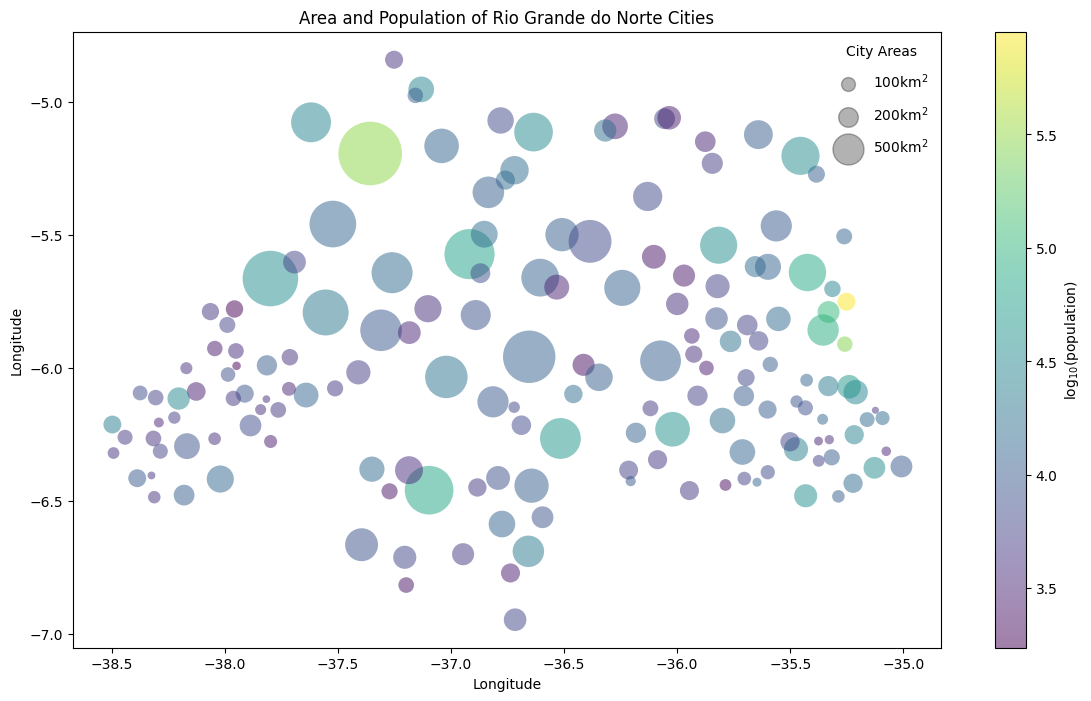

In [26]:
longitude, latitude, population, area = df_RN['lon'], df_RN['lat'], df_RN['pop'], df_RN['area']

plt.figure(figsize=(14,8))

plt.scatter(longitude, latitude, label=None, c=np.log10(population),
            cmap='viridis', s=area, linewidth=0, alpha=0.5)

plt.xlabel('Longitude')
plt.ylabel('Longitude')
plt.colorbar(label='log$_{10}$(population)')
for area in [100, 200, 500]:
    plt.scatter([], [], c='k', alpha=0.3, s=area, label=str(area) + 'km$^2$')
plt.legend(scatterpoints=1, frameon=False, labelspacing=1, title='City Areas')
plt.title("Area and Population of Rio Grande do Norte Cities")
plt.show()

### Inferences and Conclusion

The following conclusions could be drawn from the above analysis:

1. Four of the five most densely populated cities are in the state of São Paulo.

2. The ten most populous cities in brazil are the capitals of their federative units.

3. The Federative Unit of Amazonas represents approximately 18% and 2% territory and population, respectively.

4. Roraima has 2.60% of area and 0.30% of population.
